# 라이브러리 로드

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy.testing import assert_allclose

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout

# 데이터 로드

In [3]:
path = '/content/drive/MyDrive/samsung/'
df = pd.read_csv(path + 'df.csv')
test = pd.read_csv(path + 'test_clean.csv')
df.head()

,SMILES,ST1_GAP(eV)
0,CCC1CCCCN1C(=O)C(C)OC(=O)c1c(C)oc(-n2cccc2)c1C#N,1.2938
1,COc1ccc(Oc2ccc(N3C(=S)NC(c4ccccn4)C3c3cc(C)n(-...,0.2032
2,CC(=O)Nc1ccc(C(=O)[C@H](C)Sc2nnc(C3CCCCC3)o2)cc1,0.4633
3,OC(CNC1CC1)CN1CCc2sccc2C1,1.1054
4,CCNC(CCCC(F)(F)F)C1(OCC)CCOCC1,0.2243


## Y 값의 분포 확인

In [5]:
Y = df['ST1_GAP(eV)']

Text(0.5, 0, 'BP (°C)')

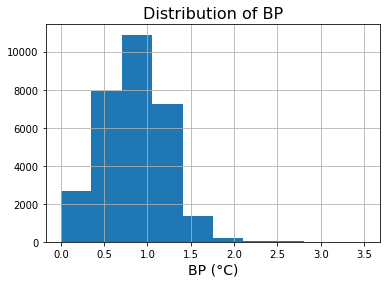

In [6]:
pd.Series(Y).hist()
plt.title('Distribution of BP', fontsize=16)
plt.xlabel('BP (°C)', fontsize = 14)

# SMILES 전처리
SMILES의 시작을 '!', 끝을 'E'로 표시

In [7]:
smiles = df['SMILES'].values
smiles[:5]

array(['CCC1CCCCN1C(=O)C(C)OC(=O)c1c(C)oc(-n2cccc2)c1C#N',
       'COc1ccc(Oc2ccc(N3C(=S)NC(c4ccccn4)C3c3cc(C)n(-c4cc(Cl)ccc4O)c3C)cc2)cc1',
       'CC(=O)Nc1ccc(C(=O)[C@H](C)Sc2nnc(C3CCCCC3)o2)cc1',
       'OC(CNC1CC1)CN1CCc2sccc2C1', 'CCNC(CCCC(F)(F)F)C1(OCC)CCOCC1'],
      dtype=object)

In [8]:
smiles = [i.replace('\n', '') for i in smiles]
smiles = [ '!' + i + 'E' for i in smiles]
smiles[:5]

['!CCC1CCCCN1C(=O)C(C)OC(=O)c1c(C)oc(-n2cccc2)c1C#NE',
 '!COc1ccc(Oc2ccc(N3C(=S)NC(c4ccccn4)C3c3cc(C)n(-c4cc(Cl)ccc4O)c3C)cc2)cc1E',
 '!CC(=O)Nc1ccc(C(=O)[C@H](C)Sc2nnc(C3CCCCC3)o2)cc1E',
 '!OC(CNC1CC1)CN1CCc2sccc2C1E',
 '!CCNC(CCCC(F)(F)F)C1(OCC)CCOCC1E']

## SMILES 데이터의 특징 확인

In [9]:
full_smiles = ''
for i in smiles:
    full_smiles +=i

In [10]:
from collections import Counter

chars = ' '.join(list(full_smiles))

# create a list of characters
chars_list = chars.split()

# Count all the words using Counter Method
count_chars = Counter(chars_list)

total_chars = len(chars_list)
sorted_chars = count_chars.most_common(total_chars)

## 정수 인코딩

In [11]:
# SMILES 를 이루는 characters 확인
unique_chars = sorted(list(set(full_smiles))) 

# Character ↔ index Mapping
char_to_int = dict((c, i) for i, c in enumerate(unique_chars)) # character → index
int_to_char = dict((i, c) for i, c in enumerate(unique_chars)) # index → character

In [12]:
char_to_int

{'!': 0,
 '#': 1,
 '%': 2,
 '(': 3,
 ')': 4,
 '+': 5,
 '-': 6,
 '/': 7,
 '0': 8,
 '1': 9,
 '2': 10,
 '3': 11,
 '4': 12,
 '5': 13,
 '6': 14,
 '7': 15,
 '8': 16,
 '9': 17,
 '=': 18,
 '@': 19,
 'B': 20,
 'C': 21,
 'E': 22,
 'F': 23,
 'H': 24,
 'I': 25,
 'N': 26,
 'O': 27,
 'P': 28,
 'S': 29,
 '[': 30,
 '\\': 31,
 ']': 32,
 'c': 33,
 'i': 34,
 'l': 35,
 'n': 36,
 'o': 37,
 'p': 38,
 'r': 39,
 's': 40}

In [13]:
int_to_char

{0: '!',
 1: '#',
 2: '%',
 3: '(',
 4: ')',
 5: '+',
 6: '-',
 7: '/',
 8: '0',
 9: '1',
 10: '2',
 11: '3',
 12: '4',
 13: '5',
 14: '6',
 15: '7',
 16: '8',
 17: '9',
 18: '=',
 19: '@',
 20: 'B',
 21: 'C',
 22: 'E',
 23: 'F',
 24: 'H',
 25: 'I',
 26: 'N',
 27: 'O',
 28: 'P',
 29: 'S',
 30: '[',
 31: '\\',
 32: ']',
 33: 'c',
 34: 'i',
 35: 'l',
 36: 'n',
 37: 'o',
 38: 'p',
 39: 'r',
 40: 's'}

정수 인코딩, 디코딩을 위한 딕셔너리의 길이 확인

In [14]:
mapping_size = len(char_to_int)
reverse_mapping_size = len(int_to_char)

print ("Size of the character to integer dictionary is: ", mapping_size)
print ("Size of the integer to character dictionary is: ", reverse_mapping_size)

Size of the character to integer dictionary is:  41
Size of the integer to character dictionary is:  41


In [15]:
# Summarize the loaded data to provide lengths for preparing datasets
n_chars = len(full_smiles)
n_vocab = len(unique_chars)

print("Total number of characters in the file is: ", n_chars) # 한 분자당 !, E 포함되어있음

Total number of characters in the file is:  1375412


In [16]:
smiles_num_list = []
for wax in smiles:
    r = [ char_to_int[w] for w in list(wax) ]
    
    
    smiles_num_list.append(r)

## 정수 인코딩된 SMILES 의 표현 예시

In [ ]:
print(smiles_num_list[0:5])

[[0, 6, 7], [0, 6, 6, 7], [0, 6, 6, 6, 7], [0, 6, 6, 6, 6, 7], [0, 6, 6, 6, 6, 6, 7]]


In [ ]:
type(full_smiles)

str

In [ ]:
' '.join(list(full_smiles))

'! C E ! C C E ! C C C E ! C C C C E ! C C C C C E ! C C C C C C E ! C C C C C C C E ! C C C C C C C C E ! C C C C C C C C C E ! C C C C C C C C C C E ! C C C C C C C C C C C E ! C C C C C C C C C C C C E ! C C C C C C C C C C C C C E ! C C C C C C C C C C C C C C E ! C C C C C C C C C C C C C C C E ! C C C C C C C C C C C C C C C C E ! C C C C C C C C C C C C C C C C C E ! C C C C C C C C C C C C C C C C C C E ! C C C C C C C C C C C C C C C C C C C E ! C C C C C C C C C C C C C C C C C C C C E ! O E ! C O E ! C C O E ! C C C O E ! C C C C O E ! C C C C C O E ! C C C C C C O E ! C C C C C C C O E ! O C C O E ! O C C C O E ! C C ( O ) C O E ! O C C ( O ) C O E ! c 1 c c c c c 1 E ! C c 1 c c c c c 1 E ! C 1 C C C C C 1 E ! C = C c 1 c c c c c 1 E ! c 1 c c c 2 c c c c c 2 c 1 E ! C C c 1 c c c c c 1 E ! N c 1 c c c c c 1 E ! C c 1 c c c ( C ) c c 1 E ! C C ( = O ) C E'

In [17]:
from collections import Counter
#all_text2 = list(smiles)

# create a list of words
words = ' '.join(list(full_smiles))

# Count all the words using Counter Method
count_words = Counter(words)

total_words = len(words)
sorted_words = count_words.most_common(total_words)

del(count_words[' ']) # 공백은 집계대상 아님

In [18]:
print(count_words)

Counter({'c': 312718, 'C': 264461, '(': 129311, ')': 129311, '1': 82876, 'O': 69997, '2': 55663, '=': 48180, 'N': 47921, '!': 30345, 'E': 30345, 'n': 29122, '3': 25262, '[': 13407, ']': 13407, 'F': 11827, '@': 10574, '-': 9953, '4': 9402, 'H': 9085, 'S': 7040, 'l': 5708, '/': 4509, 's': 4120, '5': 3590, '#': 2991, 'o': 2935, 'B': 2880, 'r': 2307, '+': 1743, '6': 1340, '\\': 1076, '7': 606, 'i': 408, 'I': 343, 'P': 270, '8': 202, '9': 88, '%': 52, '0': 30, 'p': 7})


Text(0.5, 1.0, 'Token Frequency')

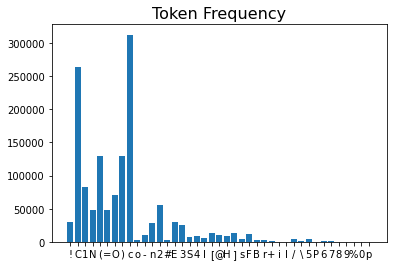

In [19]:
plt.bar(range(len(count_words)), list(count_words.values()), align='center')
plt.xticks(range(len(count_words)), list(count_words.keys()))
plt.title('Token Frequency', fontsize = 16)

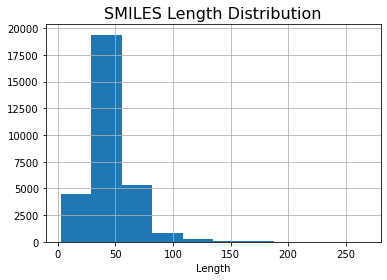

count    30345.00000
mean        45.32582
std         18.89787
min          3.00000
25%         33.00000
50%         41.00000
75%         53.00000
max        267.00000
dtype: float64

In [20]:
%matplotlib inline
wax_len = [len(x) for x in smiles_num_list]
pd.Series(wax_len).hist()
plt.title('SMILES Length Distribution', fontsize=16)
plt.xlabel('Length')
plt.show()
pd.Series(wax_len).describe()

# Padding

In [21]:
def pad_features(smiles_num_list, max_seq_length):
    ''' Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(smiles_num_list), max_seq_length), dtype = int)
    
    for i, wax in enumerate(smiles_num_list):
        wax_len = len(wax)
        
        if wax_len <= max_seq_length:
            zeroes = list(np.zeros(max_seq_length-wax_len))
            new = zeroes+wax
        elif wax_len > max_seq_length:
            new = smiles[0:max_seq_length]
        
        features[i,:] = np.array(new)
    
    return features

In [22]:
max_seq_length = max([len(a) for a in smiles_num_list])

In [23]:
for i, wax in enumerate(smiles_num_list):
    wax_len = len(wax)
    #print(wax_len)
    
    if wax_len <= max_seq_length:
        zeros = list(np.zeros(max_seq_length-wax_len))
        new = zeros+wax
        print(new)

Output hidden; open in https://colab.research.google.com to view.

In [24]:
features = pad_features(smiles_num_list, max_seq_length)
features

array([[ 0,  0,  0, ...,  1, 26, 22],
       [ 0,  0,  0, ..., 33,  9, 22],
       [ 0,  0,  0, ..., 33,  9, 22],
       ...,
       [ 0,  0,  0, ..., 10,  9, 22],
       [ 0,  0,  0, ..., 10,  9, 22],
       [ 0,  0,  0, ...,  1, 26, 22]])

In [25]:
x=features.reshape(features.shape[0],features.shape[1],1)

In [26]:
features.shape

(30345, 267)

In [27]:
a = np.array(list(range(len(char_to_int))))
a = a.reshape(-1,1)

In [28]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(a)

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

x를 원핫으로 변경

In [29]:
x_onehot = np.zeros((len(smiles), max_seq_length, len(char_to_int)))
for i in range(len(smiles)):
    x_onehot[i] = enc.transform(x[i]).toarray().reshape(max_seq_length,-1)

In [30]:
x_onehot.shape

(30345, 267, 41)

In [31]:
x_onehot[0]

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [32]:
x.shape

(30345, 267, 1)

In [ ]:
## Training, Validation, Test set split

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
x_train, x_test, y_train, y_test = train_test_split(x_onehot, Y, test_size=0.1, shuffle=True, random_state=210615)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.11, shuffle=True, random_state=210615)

In [35]:
print('training set data:',x_train.shape)
print('training set label:',y_train.shape)

print('validation set data:',x_val.shape)
print('validation set data:',y_val.shape)

print('test set data:',x_test.shape)
print('test set label:',y_test.shape)

training set data: (24305, 267, 41)
training set label: (24305,)
validation set data: (3005, 267, 41)
validation set data: (3005,)
test set data: (3035, 267, 41)
test set label: (3035,)


In [36]:
x_train.shape

(24305, 267, 41)

In [37]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(gpu_devices[0], enable=True)
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

# LSTM 학습

## Early stop 을 위한 call back

In [38]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=1000, verbose=0, mode='auto',restore_best_weights=True)

## Model build

In [39]:
"""CREATING THE LSTM MODEL"""

# Create the model (simple 2 layer LSTM)
model = Sequential()
model.add(LSTM(20, input_shape=(None, x_train.shape[2]), return_sequences = False))
model.add(Dense(10, activation ='sigmoid'))
model.add(Dense(1))

model.compile(loss = 'mse', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                4960      
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 5,181
Trainable params: 5,181
Non-trainable params: 0
_________________________________________________________________


## Training

In [ ]:
%%time
tf_device = '/GPU:1'
training = model.fit(x_train, y_train, epochs = 50000, validation_data=(x_val, y_val), batch_size = 10, callbacks=[early_stopping], verbose=0)

# Result

(319.658154296875, 1633.2819213867188)

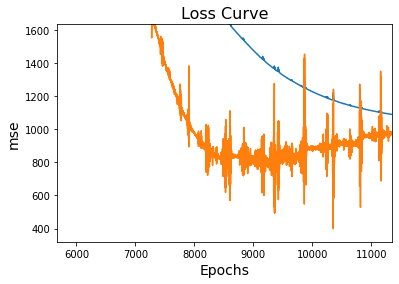

In [ ]:
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('Loss Curve', fontsize = 16)
plt.xlabel('Epochs', fontsize = 14)
plt.ylabel('mse', fontsize = 14)
plt.xlim([0.5*len(training.history['loss']), len(training.history['loss'])])
plt.ylim([0.8*min(training.history['val_loss']), 1.5*min(training.history['loss'])])

## Parity plot

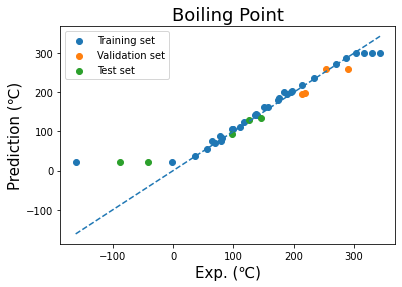

In [ ]:
plt.scatter(y_train,model.predict(x_train))
plt.scatter(y_val,model.predict(x_val))
#plt.legend(['Validation set','Test set'])
plt.scatter(y_test,model.predict(x_test))


plt.title('Boiling Point', fontsize = 18)
plt.ylabel('Prediction (℃)', fontsize=15)
plt.xlabel('Exp. (℃)', fontsize=15)

plt.legend(['Training set','Validation set','Test set'])
plt.plot([min(Y),max(Y)],[min(Y),max(Y)],'--')